## Task 2

author: 25-AI-张杰郗

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as ds
import transformers
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

d:\python\39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 数据预处理+模型定义

In [2]:
raw_train = pd.read_json("./game-chat/game_chat_train.jsonl", lines=True)
raw_test = pd.read_json("./game-chat/game_chat_validation.jsonl", lines=True)

name2id = {name: i for i, name in enumerate(raw_train['label'].unique())}
id2name = {i: name for name, i in name2id.items()}

In [3]:
tokenizer = transformers.BertTokenizer.from_pretrained('./bert-base-chinese')
bert_model = transformers.BertModel.from_pretrained('./bert-base-chinese').cuda()

我们使用预训练`bert-base-chinese`模型获取整个句子的特征，并在之后添加几个全连接层来完成这个特定的分类问题

In [4]:
train_tokenized = [tokenizer(sentence, return_tensors="pt") for sentence in raw_train['sentence'].tolist()]
train_labels = [name2id[label] for label in raw_train['label'].tolist()]

test_tokenized = [tokenizer(sentence, return_tensors="pt") for sentence in raw_test['sentence'].tolist()]
test_labels = [name2id[label] for label in raw_test['label'].tolist()]

In [5]:
class Dataset(ds.Dataset):
    def __init__(self, tokenized_data, labels):
        self.tokenized_data = tokenized_data
        self.labels = labels
        self.bert_model = bert_model

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = {k: v.squeeze(0).cuda() for k, v in self.tokenized_data[idx].items()}
        label = torch.tensor(self.labels[idx]).cuda()
        return data, label

def collate_fn(batch):
    keys = batch[0][0].keys()

    padded_data = {k: [data[0][k] for data in batch] for k in keys}
    padded_data = {k: torch.nn.utils.rnn.pad_sequence(v, batch_first=True, padding_value=0) for k, v in padded_data.items()}
    labels = torch.tensor([data[1] for data in batch]).cuda()

    return padded_data, labels

In [6]:
torch.manual_seed(518)

train_dataset = Dataset(train_tokenized, train_labels)
test_dataset = Dataset(test_tokenized, test_labels)

train_loader = ds.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = ds.DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [7]:
class BertTuningModel(nn.Module):
    def __init__(self, dropout=0.4):
        """
        bert output: 768
        """
        super(BertTuningModel, self).__init__()
        
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 5)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(dropout)

        return
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return self.softmax(x)

class AllTuningModel(nn.Module):
    def __init__(self, bert_model, dropout=0.4):
        """
        bert output: 768
        """
        super(AllTuningModel, self).__init__()
        self.bert = bert_model
        
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 5)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(dropout)

        return
    
    def forward(self, x):
        x = self.bert(**x).last_hidden_state[:, 0, :]
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return self.softmax(x)

### 模型训练

#### 冻结BERT:

In [8]:
torch.manual_seed(518)

epoches = 100
loss_cache = []

model = BertTuningModel().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(epoches):
    total_loss = 0

    for data, labels in train_loader:
        with torch.no_grad():
            data = bert_model(**data).last_hidden_state[:, 0, :]
            
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    loss_cache.append(total_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 1.479010410308838
Epoch 2, Loss: 1.3872967227300008
Epoch 3, Loss: 1.3253716135025024
Epoch 4, Loss: 1.2733974409103395
Epoch 5, Loss: 1.2327502218882243
Epoch 6, Loss: 1.2063191556930541
Epoch 7, Loss: 1.1725103537241617
Epoch 8, Loss: 1.1501349687576294
Epoch 9, Loss: 1.1400600210825602
Epoch 10, Loss: 1.1210929600397745
Epoch 11, Loss: 1.110916870435079
Epoch 12, Loss: 1.100357612768809
Epoch 13, Loss: 1.0944111561775207
Epoch 14, Loss: 1.0869723773002624
Epoch 15, Loss: 1.079252056280772
Epoch 16, Loss: 1.0798787220319113
Epoch 17, Loss: 1.075239253838857
Epoch 18, Loss: 1.069312022527059
Epoch 19, Loss: 1.0663175916671752
Epoch 20, Loss: 1.0701325011253358
Epoch 21, Loss: 1.058583883444468
Epoch 22, Loss: 1.0591614898045858
Epoch 23, Loss: 1.0585613067944843
Epoch 24, Loss: 1.0534438212712607
Epoch 25, Loss: 1.052575446764628
Epoch 26, Loss: 1.0433027712504068
Epoch 27, Loss: 1.047798744837443
Epoch 28, Loss: 1.0432393034299214
Epoch 29, Loss: 1.0379204082489013
Epo

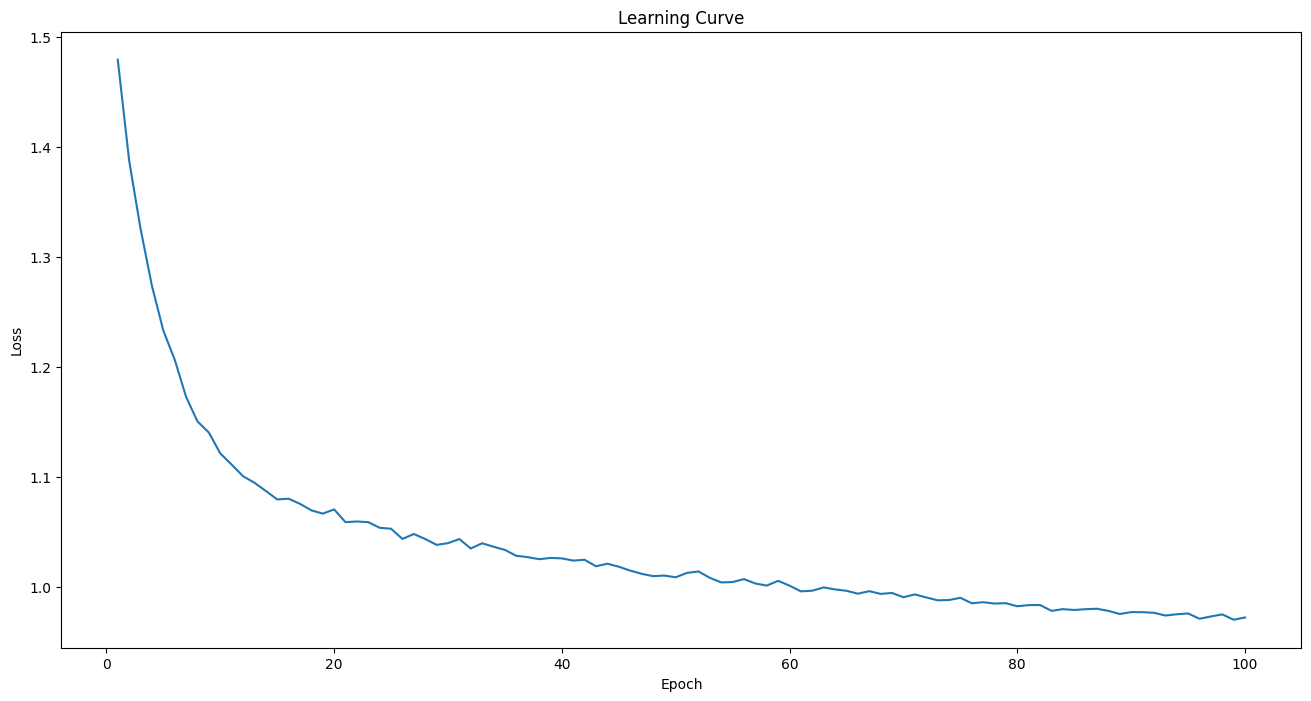

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(range(1, epoches + 1), loss_cache)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()

100 epoches:
![learning curve](./images\bert-tuning_classifier-100-0.4.png "100")
300 epoches:
![learning curve](./images\bert-tuning_classifier-300-0.4.png "300")

In [11]:
torch.save(model, "./models/task2/bert-tuning_classifier-100-0.4.pth")

#### 微调全部:

In [8]:
torch.manual_seed(518)

epoches = 100
loss_cache = []

model = AllTuningModel(bert_model).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(epoches):
    total_loss = 0

    for data, labels in train_loader:            
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    loss_cache.append(total_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

Epoch 1, Loss: 1.5932511250178019
Epoch 2, Loss: 1.566044527689616
Epoch 3, Loss: 1.5309828567504882
Epoch 4, Loss: 1.502299124399821
Epoch 5, Loss: 1.4760496187210084
Epoch 6, Loss: 1.462254581451416
Epoch 7, Loss: 1.4421733172734579
Epoch 8, Loss: 1.42672736008962
Epoch 9, Loss: 1.4079540713628134
Epoch 10, Loss: 1.3901193491617838
Epoch 11, Loss: 1.3706152296066285
Epoch 12, Loss: 1.3549751631418865
Epoch 13, Loss: 1.3303849681218465
Epoch 14, Loss: 1.3171360699335735
Epoch 15, Loss: 1.2990274365743002
Epoch 16, Loss: 1.2896403694152831
Epoch 17, Loss: 1.275150473912557
Epoch 18, Loss: 1.260205659866333
Epoch 19, Loss: 1.2449983167648315
Epoch 20, Loss: 1.2317852719624838
Epoch 21, Loss: 1.218019110361735
Epoch 22, Loss: 1.2098673899968466
Epoch 23, Loss: 1.1966023445129395
Epoch 24, Loss: 1.184498127301534
Epoch 25, Loss: 1.1706803115208944
Epoch 26, Loss: 1.1561237700780234
Epoch 27, Loss: 1.147408094406128
Epoch 28, Loss: 1.13756635983785
Epoch 29, Loss: 1.1264505545298258
Epoch 

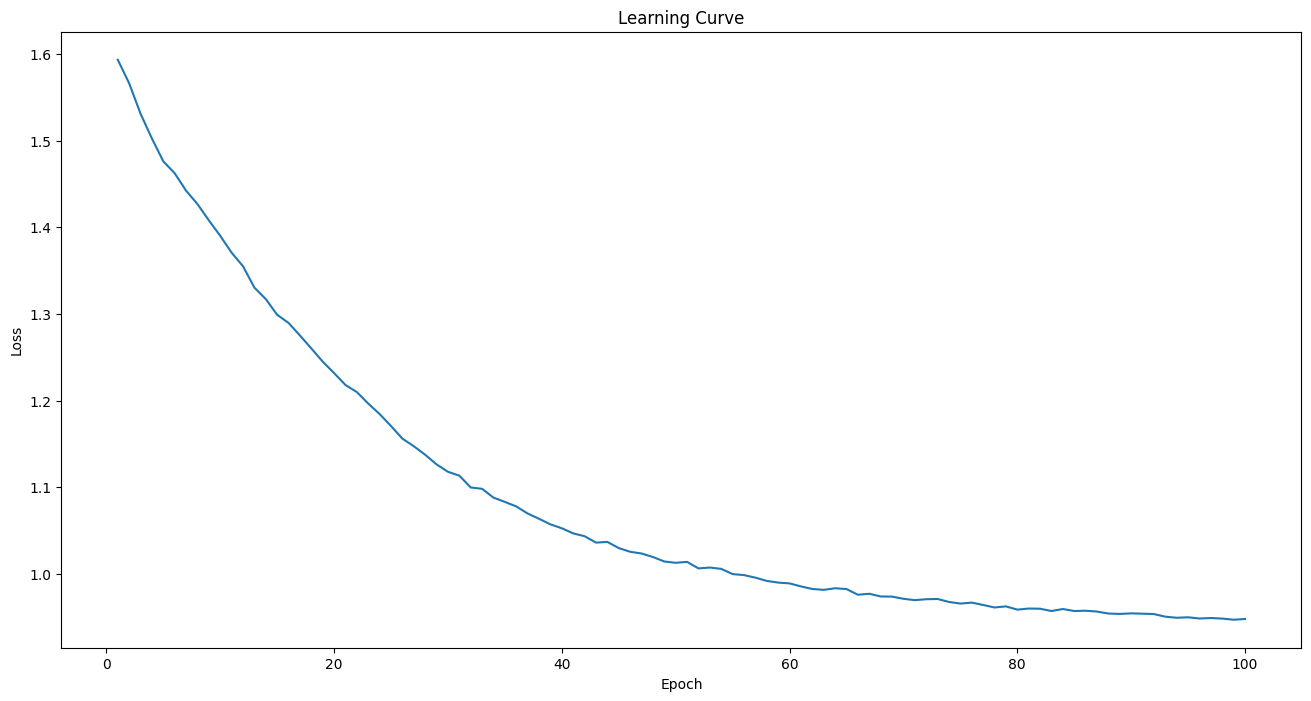

In [9]:
plt.figure(figsize=(16, 8))
plt.plot(range(1, epoches + 1), loss_cache)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()

100 epoches:
![learning curve](./images/all-tuning_classifier-100-0.4.png "100")
300 epoches:
![learning curve](./images/all-tuning_classifier-300-0.4.png "300")

In [11]:
torch.save(model, "./models/task2/all-tuning_classifier-100-0.4.pth")

### 模型评估

In [12]:
model = torch.load("./models/task2/bert-tuning_classifier-100-0.4.pth", weights_only=False)
model.eval()

preds = []
for data, labels in test_loader:
    with torch.no_grad():
        data = bert_model(**data).last_hidden_state[:, 0, :]

    outputs = model(data)
    outputs = torch.argmax(outputs, dim=1)
    preds.extend(outputs.tolist())

test_true = raw_test['label'].map(lambda x: name2id[x]).tolist()
acc = metrics.accuracy_score(test_true, preds)
precision = metrics.precision_score(test_true, preds, average='macro')
recall = metrics.recall_score(test_true, preds, average='macro')
f1 = metrics.f1_score(test_true, preds, average='macro')
print("冻结BERT参数，仅微调分类器(100 epoches)：")
print("-"*60, "\n", f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1-score: {f1}", "\n", "-"*60)
print("\n\n")


model = torch.load("./models/task2/bert-tuning_classifier-300-0.4.pth", weights_only=False)
model.eval()

preds = []
for data, labels in test_loader:
    with torch.no_grad():
        data = bert_model(**data).last_hidden_state[:, 0, :]

    outputs = model(data)
    outputs = torch.argmax(outputs, dim=1)
    preds.extend(outputs.tolist())

test_true = raw_test['label'].map(lambda x: name2id[x]).tolist()
acc = metrics.accuracy_score(test_true, preds)
precision = metrics.precision_score(test_true, preds, average='macro')
recall = metrics.recall_score(test_true, preds, average='macro')
f1 = metrics.f1_score(test_true, preds, average='macro')
print("冻结BERT参数，仅微调分类器(300 epoches)：")
print("-"*60, "\n", f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1-score: {f1}", "\n", "-"*60)

d:\python\39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


冻结BERT参数，仅微调分类器(100 epoches)：
------------------------------------------------------------ 
 Accuracy: 0.8308144416456759, Precision: 0.4874134096300609, Recall: 0.4910840623523855, F1-score: 0.4892220975311162 
 ------------------------------------------------------------



冻结BERT参数，仅微调分类器(300 epoches)：
------------------------------------------------------------ 
 Accuracy: 0.8299748110831234, Precision: 0.4893362286475881, Recall: 0.48845804440245627, F1-score: 0.48874677326230004 
 ------------------------------------------------------------


d:\python\39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model = torch.load("./models/task2/all-tuning_classifier-100-0.4.pth", weights_only=False)
model.eval()

preds = []
for data, labels in test_loader:
    outputs = model(data)
    outputs = torch.argmax(outputs, dim=1)
    preds.extend(outputs.tolist())
    
test_true = raw_test['label'].map(lambda x: name2id[x]).tolist()
acc = metrics.accuracy_score(test_true, preds)
precision = metrics.precision_score(test_true, preds, average='macro')
recall = metrics.recall_score(test_true, preds, average='macro')
f1 = metrics.f1_score(test_true, preds, average='macro')
print("微调全部(100 epoches)：")
print("-"*60, "\n", f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1-score: {f1}", "\n", "-"*60)
print("\n\n")


model = torch.load("./models/task2/all-tuning_classifier-300-0.4.pth", weights_only=False)
model.eval()

preds = []
for data, labels in test_loader:
    outputs = model(data)
    outputs = torch.argmax(outputs, dim=1)
    preds.extend(outputs.tolist())
    
test_true = raw_test['label'].map(lambda x: name2id[x]).tolist()
acc = metrics.accuracy_score(test_true, preds)
precision = metrics.precision_score(test_true, preds, average='macro')
recall = metrics.recall_score(test_true, preds, average='macro')
f1 = metrics.f1_score(test_true, preds, average='macro')
print("微调全部(300 epoches)：")
print("-"*60, "\n", f"Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1-score: {f1}", "\n", "-"*60)

d:\python\39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


微调全部(100 epoches)：
------------------------------------------------------------ 
 Accuracy: 0.874895046179681, Precision: 0.5195601154354985, Recall: 0.5201507038261691, F1-score: 0.5195585391994625 
 ------------------------------------------------------------

 

微调全部(300 epoches)：
------------------------------------------------------------ 
 Accuracy: 0.8786733837111671, Precision: 0.52065083700722, Recall: 0.5234831365139347, F1-score: 0.5218486890659365 
 ------------------------------------------------------------


d:\python\39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
